### 1. Install Dependencies And Setup Environment

In [ ]:
! pip install tensorflow opencv-python matplotlib

In [3]:
import tensorflow as tf
import os

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

### 2. Remove Dodgy Images

In [7]:
import cv2
import imghdr

In [8]:
data_directory = 'data'

In [9]:
image_extensions = ['jpg', 'jpeg', 'png', 'bmp']

In [16]:
for image_class in os.listdir(data_directory):
    for image in os.listdir(os.path.join(data_directory , image_class)) :
        image_path = os.path.join(data_directory , image_class , image)
        try :
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions :
                print(image_path)
                os.remove(image_path)
        except Exception as e :
            print(e)
            print(image_path)
            os.remove(image_path)


### 3. Load Data

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [21]:
data = tf.keras.utils.image_dataset_from_directory(data_directory)

Found 305 files belonging to 2 classes.


In [22]:
data_iterator = data.as_numpy_iterator()

In [30]:
batch = data_iterator.next()
# min = 0 , max = 255

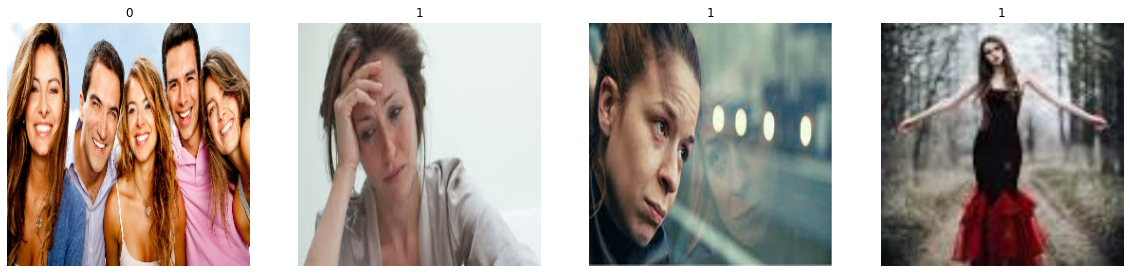

In [33]:
fig , ax = plt.subplots(ncols= 4 , figsize = (20 , 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(np.uint8))
    ax[idx].set_title(batch[1][idx])
    ax[idx].axis('off')

In [34]:
image_classes = ['happy' , 'sad']

### 4. Scale Data

In [35]:
data = data.map(lambda x,y : (x/255 , y))

In [ ]:
data.as_numpy_iterator().next()

### 5. Split Data

In [43]:
train_size = int(len(data) * 0.7)
evaluation_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

train_size , evaluation_size , test_size

(7, 2, 1)

In [84]:
train = data.take(train_size)
valuation = data.skip(train_size).take(evaluation_size)
test = data.skip(train_size + evaluation_size).take(test_size)

### 6. Build Model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dense , Dropout

In [76]:
model = Sequential()

In [77]:
model.add(Conv2D(16 , (3,3) , activation='relu' , input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32 , (3,3) , activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16 , (3,3) , 1 , activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256 , activation='relu'))
model.add(Dense(1 , activation='sigmoid'))

In [79]:
model.compile('adam' , loss= tf.losses.BinaryCrossentropy() , metrics=['accuracy'])

In [80]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 30, 30, 16)      

### 7. Train Model

In [81]:
log_directory = 'logs'

In [82]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_directory)

In [ ]:
history = model.fit(train , epochs=20 , validation_data=valuation , callbacks=[tensorboard_callback])

### 8. Plot Performance

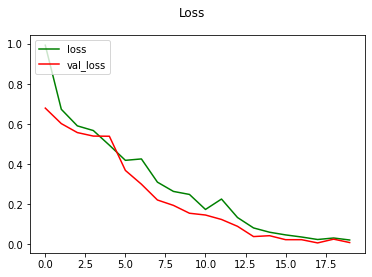

In [89]:
fig = plt.figure()
plt.plot(history.history['loss'] , label='loss' , color='green')
plt.plot(history.history['val_loss'] , label='val_loss' , color='red')
fig.suptitle('Loss')
plt.legend(loc = 'upper left')
plt.show()

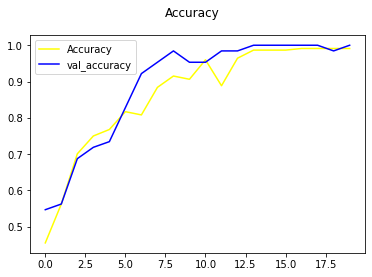

In [91]:
fig = plt.figure()
plt.plot(history.history['accuracy'] , label='Accuracy' , color='yellow')
plt.plot(history.history['val_accuracy'] , label='val_accuracy' , color='blue')
fig.suptitle('Accuracy')
plt.legend(loc = 'upper left')
plt.show()

### 9. Evaluate Model

In [93]:
from tensorflow.keras.metrics import Precision , Recall , BinaryAccuracy

In [94]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [96]:
for batch in test.as_numpy_iterator():
    x , y = batch
    yhat = model.predict(x)
    pre.update_state(y , yhat)
    rec.update_state(y , yhat)
    acc.update_state(y , yhat)

1/1 [==============================] - 0s 191ms/step


In [97]:
print(pre.result() , rec.result() , acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


### 10. Test

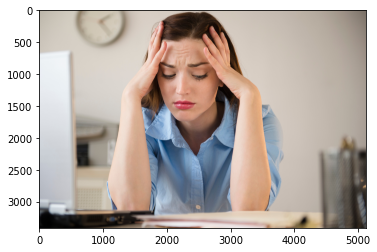

In [126]:
img = cv2.imread('data/sad/crying-at-work.jpg')
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

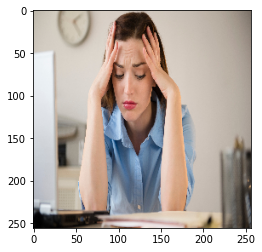

In [127]:
resize = tf.image.resize(img , (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [129]:
yhat = model.predict(np.expand_dims(resize/255 , 0))

1/1 [==============================] - 0s 35ms/step


In [130]:
image_classes[round(yhat[0][0])]

'sad'

### 11. Save Model

In [132]:
from tensorflow.keras.models import load_model

In [133]:
model.save('models/happy_sad_model.h5')

In [134]:
new_model = load_model('models/happy_sad_model.h5')

In [135]:
yhat = new_model.predict(np.expand_dims(resize/255 , 0))

1/1 [==============================] - 0s 222ms/step


In [136]:
image_classes[round(yhat[0][0])]

'sad'